# A simple quantum neural network to learn DIS stock prices

Before pursuing an adversarial learning approach, I wanted to first benchmark the results from a conventional quantum neural network. The following notebook defines a 12 qubit quantum neural network. The first register takes as input the "labels" of shape (1,15) which encode DIS stock prices which have been processed to percentage differences of consecutive close prices. These entries were further normalized to [-1, 1]. The second register of 4 qubits is intended to emulate gaussian noise which is intended to help with generalization and regularization. To implement gaussian noise on a quantum circuit, I fed samples of a normal distribution to 4 arbitrary single qubit unitaries. With additional computational resources, I would have trained the model to a point of convergence or failure mode beyond 10 epochs.

Indeed, there are theories that stock market prices are in fact random (rendering them unlearnable). I do not agree or disagree and I acknowledge the difficulty of learning stock market price data (if possible), especially from such a small time window, but this is simply meant to be an explorative exercise to help benchmark an adversarial learning strategy. 

<hr>

## Imports

In [362]:
import datetime
import time
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Equities: `['MSFT', 'DIS', 'HAS', 'JNJ', 'ADBE', 'V']`

dataset structure: `[equity number][train or test][sample number][past or future daily close prices (normalized percentage difference)]`

In [260]:
dataset = np.load('data/prices_8_2.npy', allow_pickle=True)

In [261]:
dis_dataset = dataset[1] # normalized percentage diff close prices of DIS

## Exploring dataset structure

In [739]:
print(dis_dataset.shape)
print(len(dis_dataset[0])) # Training samples 
print(len(dis_dataset[1])) # Test/validation samples

(2,)
2425
607


In [740]:
print(dis_dataset[0][0]) # Example sample (8 days as input + 2 days as prediction)

[array([-0.82728635, -0.342089  ,  1.        , -0.28558829, -0.87136482,
        0.88597643,  0.12449377, -0.65481359]), array([-0.65481359, -0.77422718])]


## Defining training/testing data

In [677]:
x_train, y_train = list(), list()
x_val, y_val = list(), list()
x_test, y_test = list(), list()

for i in range(len(dis_dataset[0])):
    x_train.append(dis_dataset[0][i][0])
    y_train.append(dis_dataset[0][i][1])

for i in range(len(dis_dataset[1])):
    if i <= len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_val.append(dis_dataset[1][i][0])
        y_val.append(dis_dataset[1][i][1])
    
    if i > len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_test.append(dis_dataset[1][i][0])
        y_test.append(dis_dataset[1][i][1])

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_val, y_val = np.asarray(x_val), np.asarray(y_val)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

In [262]:
print(dis_dataset[0][235]) # arbitrary data sample (first array = features or past price data, second array = labels or consecutive price data)

[array([-0.46887648,  0.0977642 ,  0.06507283,  0.01626297,  0.43866476,
        1.        , -0.39665027, -0.35135366]), array([-0.35135366, -0.19277046])]


## QNN Structure

In [693]:
wires = range(len(dis_dataset[0][0][0]) + latent_dim) # 12 , b=8, f=2
n_layers = 3
latent_dim = 4
dev = qml.device('default.qubit', wires=wires)

In [694]:
@qml.qnode(dev, interface="tf")
def qnn(inputs, weights):
    # Embedding past time series onto circuit
    qml.templates.AngleEmbedding(inputs, wires[:len(dis_dataset[0][1][0])], rotation='X')
    
    # Gaussian noise through U3 unitaries
    latent_points = np.random.normal(size=(latent_dim, 3))
    qml.broadcast(unitary=qml.U3, wires=wires[-latent_dim:], pattern="single", parameters=latent_points)
    
    # Ansatz of choice
    qml.templates.StronglyEntanglingLayers(weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

## Building model with QNN as Keras Layer

In [698]:
mse = tf.keras.losses.MeanSquaredError()
def accuracy(y_true, y_pred):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(y_true, y_pred)
    acc = 1 - m.result().numpy()
    return acc

In [334]:
opt = tf.keras.optimizers.Adam(lr=0.0002)

In [696]:
# Define Keras model
weight_shapes = {"weights": (n_layers,len(wires),3)}
qlayer = qml.qnn.KerasLayer(qnn, weight_shapes, output_dim=2)
model = tf.keras.models.Sequential([qlayer])
model.compile(loss=mse, optimizer=opt)

## Training 

In [701]:
history = model.fit(x_train, y_train, batch_size=60, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
41/41 [==============================] - 637s 16s/step - loss: 0.3213 - val_loss: 0.3393
Epoch 2/10
41/41 [==============================] - 640s 16s/step - loss: 0.3121 - val_loss: 0.3292
Epoch 3/10
41/41 [==============================] - 643s 16s/step - loss: 0.3078 - val_loss: 0.3170
Epoch 4/10
41/41 [==============================] - 645s 16s/step - loss: 0.3051 - val_loss: 0.3184
Epoch 5/10
41/41 [==============================] - 645s 16s/step - loss: 0.3034 - val_loss: 0.3151
Epoch 6/10
41/41 [==============================] - 648s 16s/step - loss: 0.3012 - val_loss: 0.3124
Epoch 7/10
41/41 [==============================] - 649s 16s/step - loss: 0.2998 - val_loss: 0.3141
Epoch 8/10
41/41 [==============================] - 650s 16s/step - loss: 0.2956 - val_loss: 0.2986
Epoch 9/10
41/41 [==============================] - 650s 16s/step - loss: 0.2956 - val_loss: 0.3072
Epoch 10/10
41/41 [==============================] - 652s 16s/step - loss: 0.2948 - val_loss: 0.3090

## Result metrics

In [742]:
# Model evaluated on test dataset
y_test_preds = model.__call__(x_test)
print(f"Average accuracy on test dataset: {accuracy(y_test, y_test_preds)}")

Average accuracy on test dataset: 0.559234619140625


As expected due to the difficulty of accurately predicting stock market data, we can observe that this simple quantum neural network has not converged.

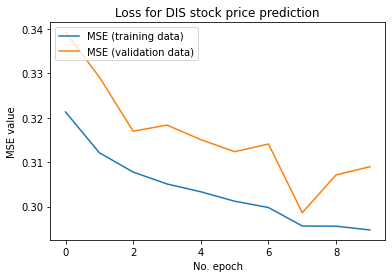

In [711]:
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('Loss for DIS stock price prediction')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Visualizing prediction performance

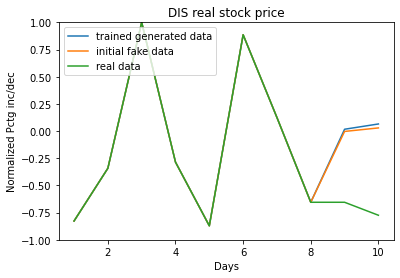

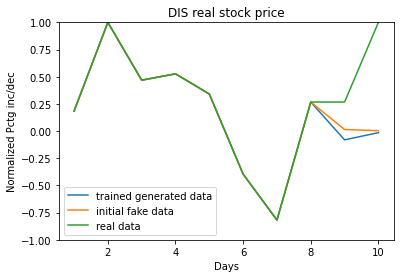

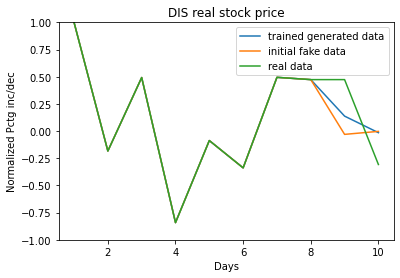

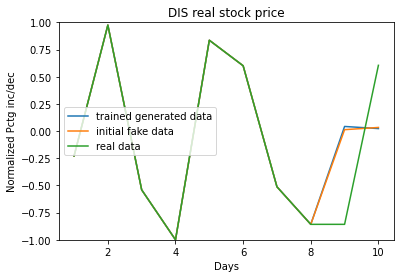

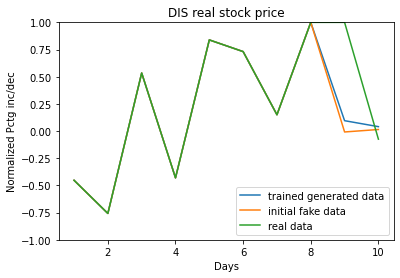

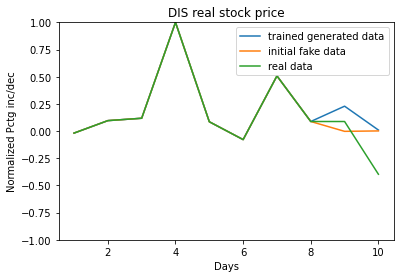

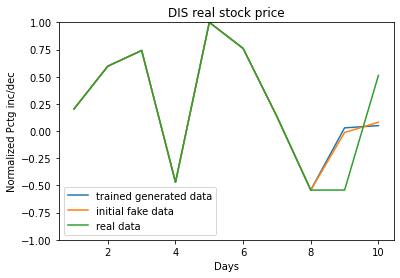

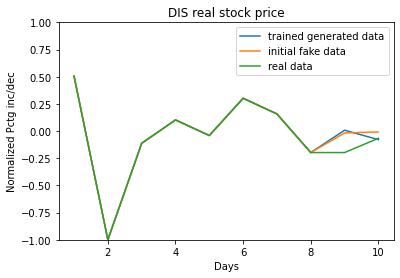

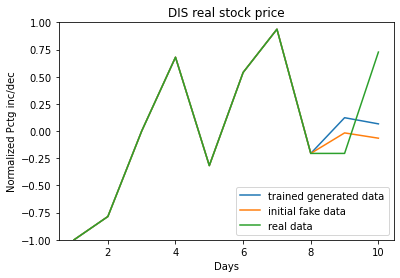

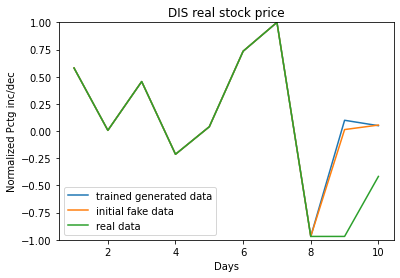

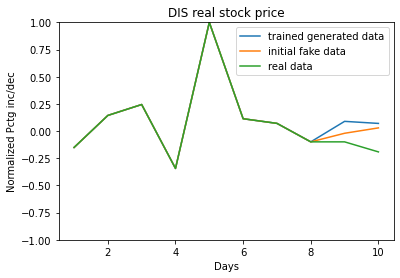

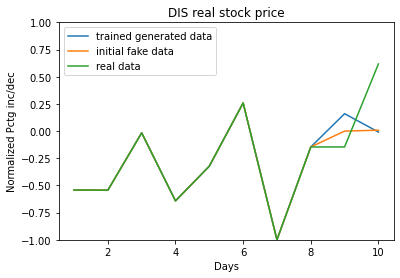

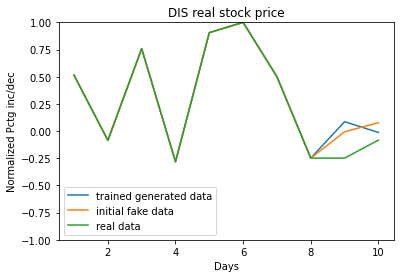

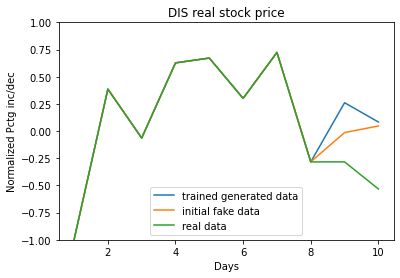

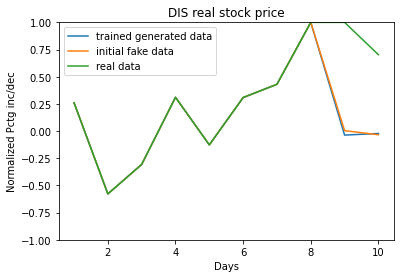

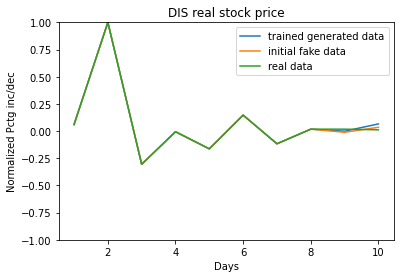

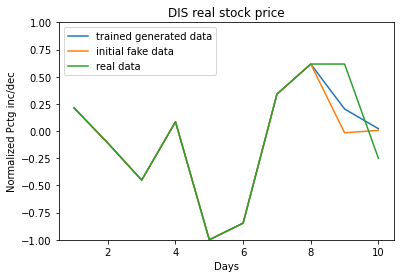

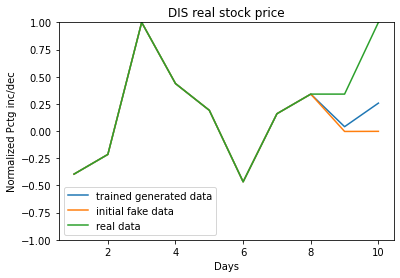

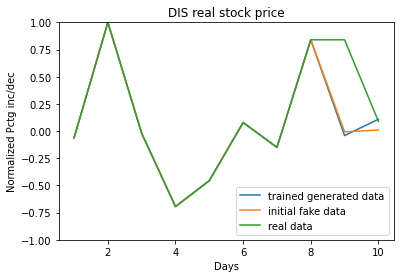

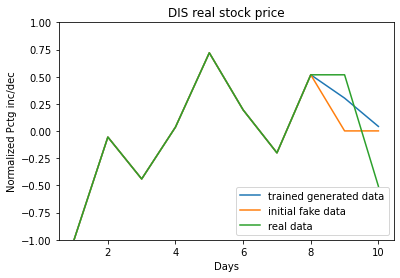

In [733]:
for i in range(20):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], model.__call__(dis_dataset[0][i][0])], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], qnn(dis_dataset[0][i][0], init_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.ylim(-1, 1)
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()

<hr>